# 保险数据集回归模型
实战基于数据集 AllstateClaimsSeverity (Kaggle2016竞赛) ：

官网：https://www.kaggle.com/c/allstate-claims-severity/overview

基于给出的数据预测保险赔偿。给出的训练数据是116列（cat1-cat116）的离散数据和14列（con1-con14）的连续数据。

## 一、数据集
导入依赖

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection  import cross_val_score

from scipy import stats
import seaborn as sns
from copy import deepcopy

%matplotlib inline

%config InlineBackend.figure_format = 'retina'

加载数据集

In [2]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [3]:
print('First 20 columns:',list(train.columns[:20]))
print('Last 20 columns:',list(train.columns[-20:]))

First 20 columns: ['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19']
Last 20 columns: ['cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'loss']


观察得到：一共有 object 类型属性 116 个，float64 属性15个，int64 属性 1 个，其中 id 是int64，loss 赔偿是 float64.

In [4]:
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


查看缺失值

In [5]:
pd.isnull(train).values.any()

False

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [7]:
cat_features = list(train.select_dtypes(include=['object']))
print('离散特征Categorical: {} features'.format(len(cat_features)))

离散特征Categorical: 116 features


查看离散特征和连续特征个数

In [8]:
cont_features = [cont for cont in list(train.select_dtypes(include=['float64','int64'])) if cont not in ['loss','id']]
print('连续特征Continuous: {} features'.format(len(cont_features)))

连续特征Continuous: 14 features


In [9]:
id_col = list(train.select_dtypes(include=['int64']))
print('A column of int64:{}'.format(id_col))

A column of int64:['id']


类别值中属性的个数

In [10]:
#统计类别属性中不同类别的个数
cat_uniques=[]
for cat in cat_features:    
    cat_uniques.append(len(train[cat].unique())) 
# cat_uniques

In [11]:
# uniq_values_in_categories = pd.DataFrame.from_dict([('cat_name':cat_features),('unique_values':cat_uniques)])
uniq_values_in_categories = pd.DataFrame.from_dict({'cat_name':cat_features,'unique_values':cat_uniques})
uniq_values_in_categories.head()

,cat_name,unique_values
0,cat1,2
1,cat2,2
2,cat3,2
3,cat4,2
4,cat5,2


Text(7,71,'Binary features')

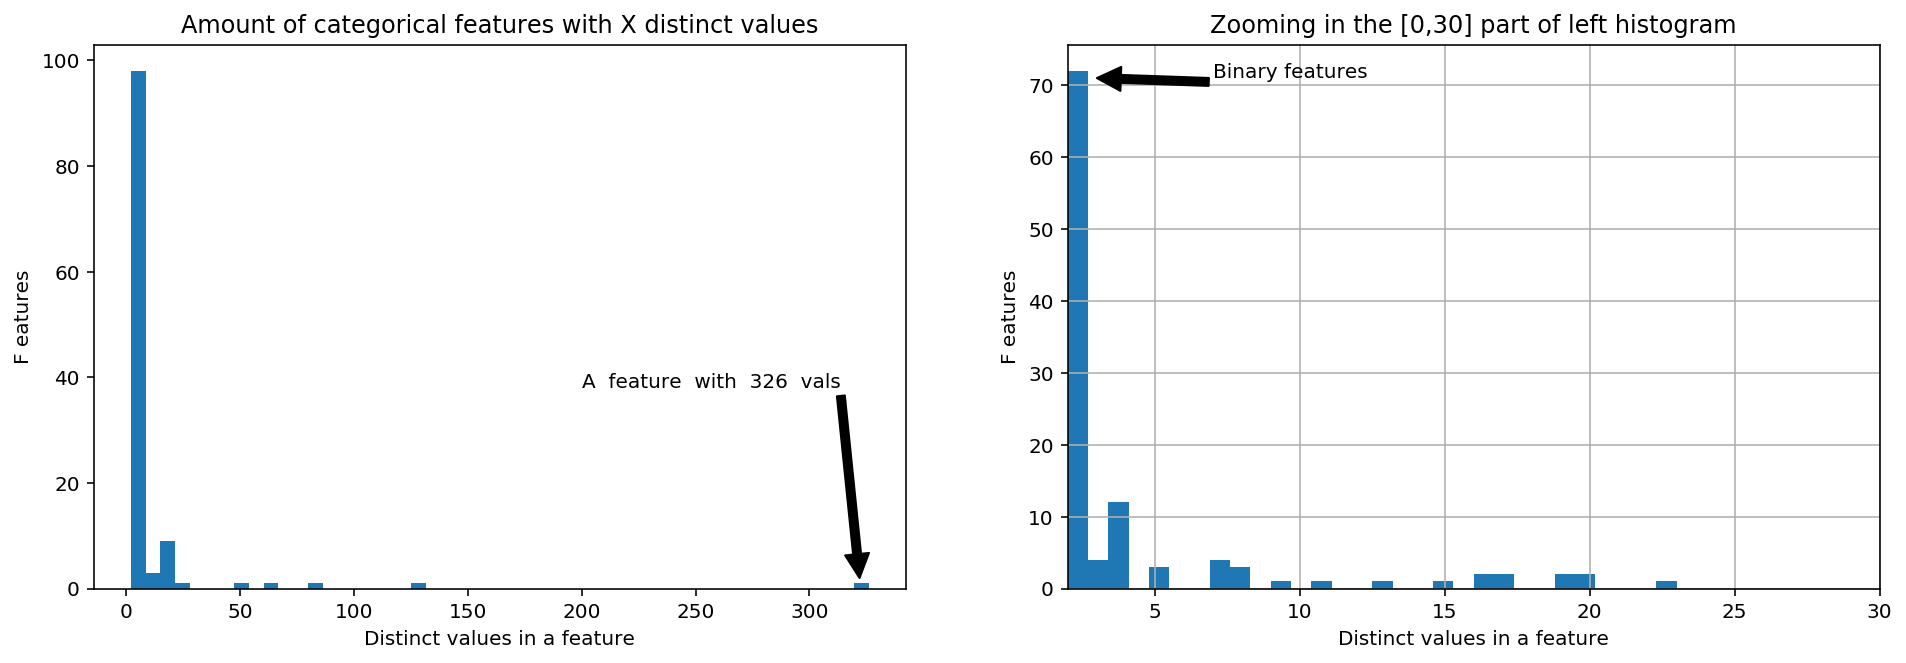

In [12]:
fig,(ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)

ax1.hist(uniq_values_in_categories.unique_values, bins=50)
ax1.set_title('Amount of categorical features with X distinct values')#离散特征值分布情况
ax1.set_xlabel('Distinct values in a feature')
ax1.set_ylabel('F eatures')
ax1.annotate('A  feature  with  326  vals', xy=(322, 2), xytext=(200,  38),arrowprops=dict(facecolor='black'))

ax2.set_xlim(2,30)
ax2.set_title('Zooming in the [0,30] part of left histogram')
ax2.set_xlabel('Distinct values in a feature')
ax2.set_ylabel('F eatures')
ax2.grid(True)
ax2.hist(uniq_values_in_categories[uniq_values_in_categories.unique_values<=30].unique_values, bins=30)
ax2.annotate('Binary features', xy=(3, 71), xytext=(7, 71), arrowprops=dict(facecolor='black'))

正如我们所看到的，大部分的分类特征（72/116）是二值的，绝大多数特征（88/116）有四个值，其中有一个具有326个值的特征（一天的数量？）。

赔偿值

C:\Users\36942\AppData\Roaming\Python\Python36\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\36942\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\36942\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


train['id']个数: 188318


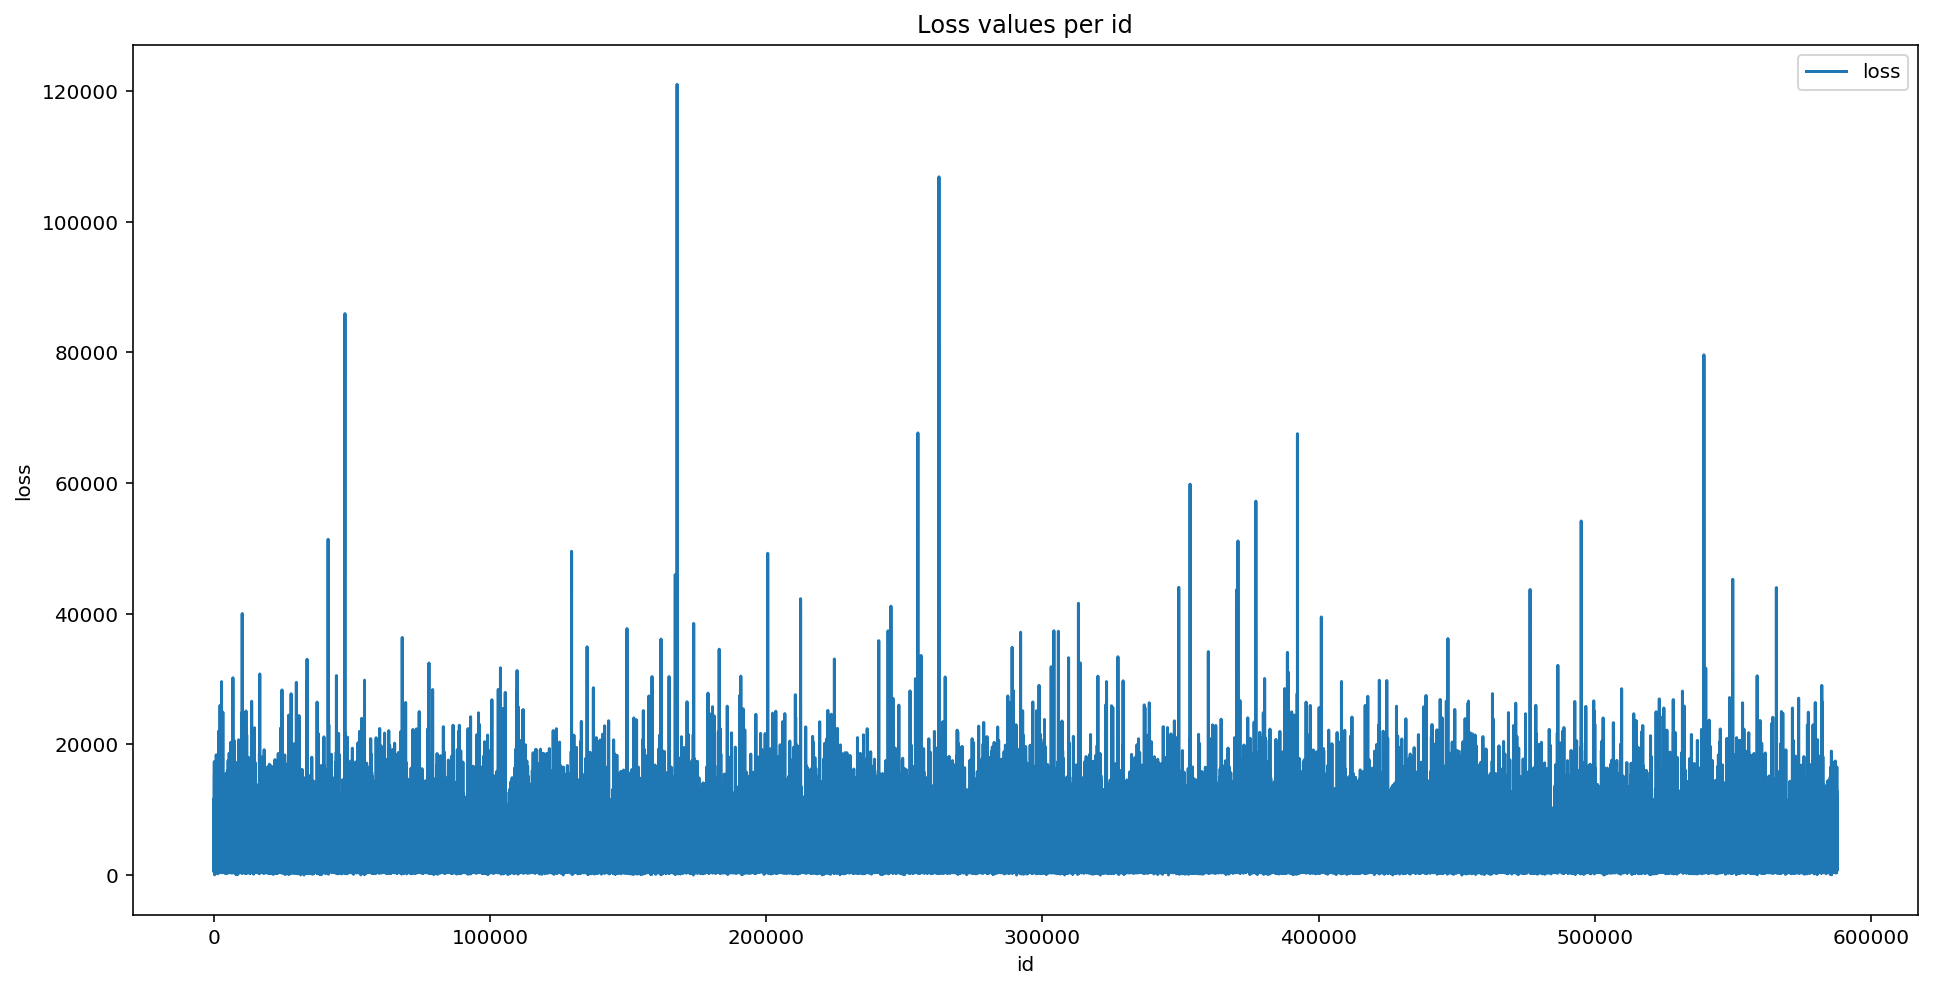

In [13]:
plt.figure(figsize=(16,8))
plt.plot(train['id'],train['loss'])
print('train[\'id\']个数:',len(train['id']))
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()

如上图所示，损失值有几个显著的峰值，表示严重事故。这样的数据分布，使得这个功能非常扭曲导致回归表现不佳。

基本上，偏度 度量了实值随机变量的均值分布的不对称性，下面让我们来计算一下loss的偏度：

In [14]:
#scipy.stats 统计指标。
stats.mstats.skew(train['loss']).data
#输出：array(3.79492815)

array(3.79492815)

偏度值比1大，说明数据是倾斜的。不利于数据建模。我们利用对数变换np.log，使倾斜降低。

In [15]:
stats.mstats.skew(np.log(train['loss'])).data
#输出：array(0.0929738)

array(0.0929738)

两种 loss 分布对比：

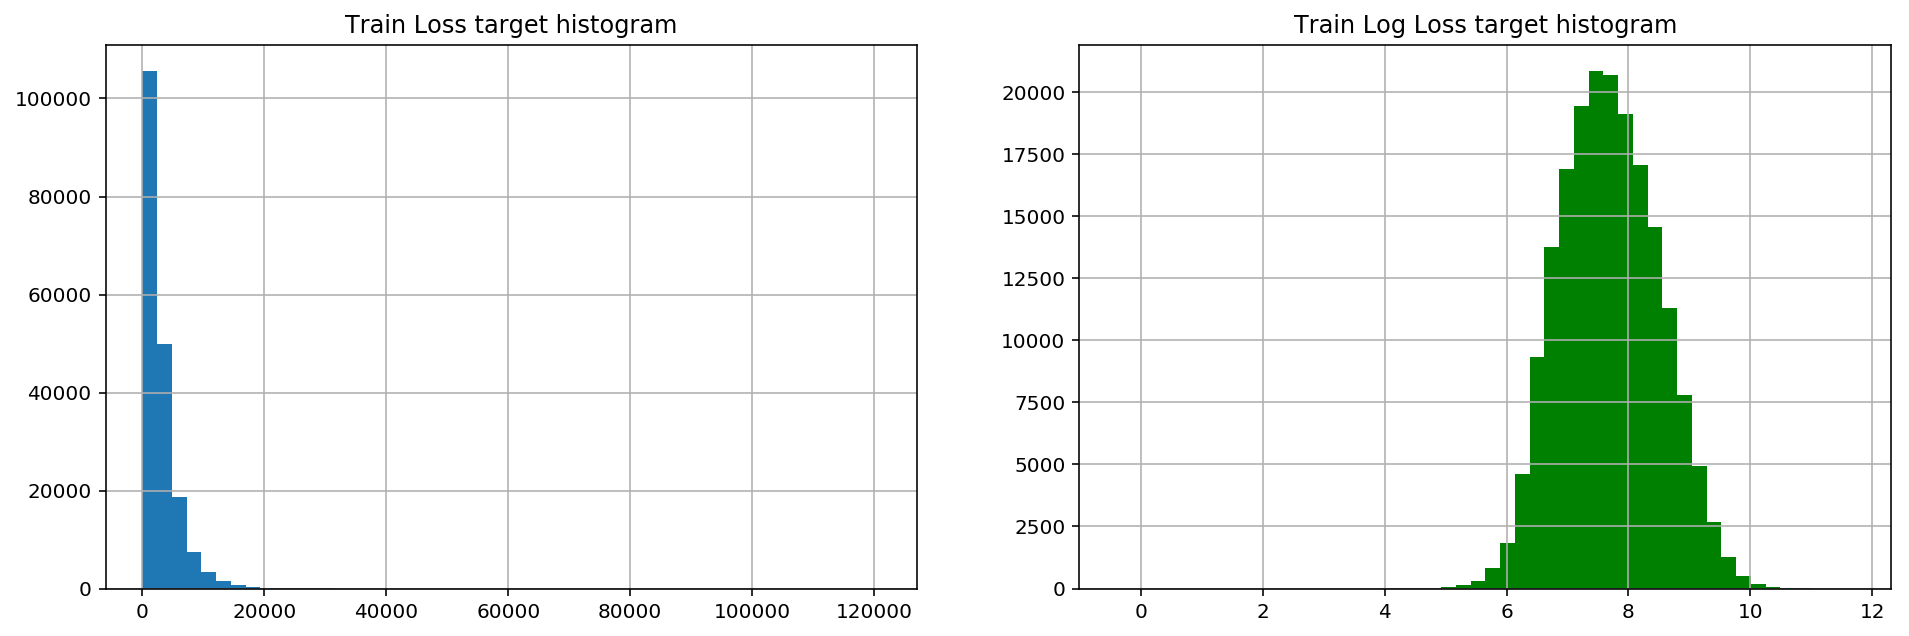

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train['loss'], bins=50)
ax1.set_title('Train Loss target histogram')
ax1.grid(True)
ax2.hist(np.log(train['loss']), bins=50, color='g')
ax2.set_title("Train Log Loss target histogram")
ax2.grid(True)
plt.show()

数据loss对数化之后，是我们喜欢的分布类型。

连续值特征

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026404D027F0>,
      dtype=object)

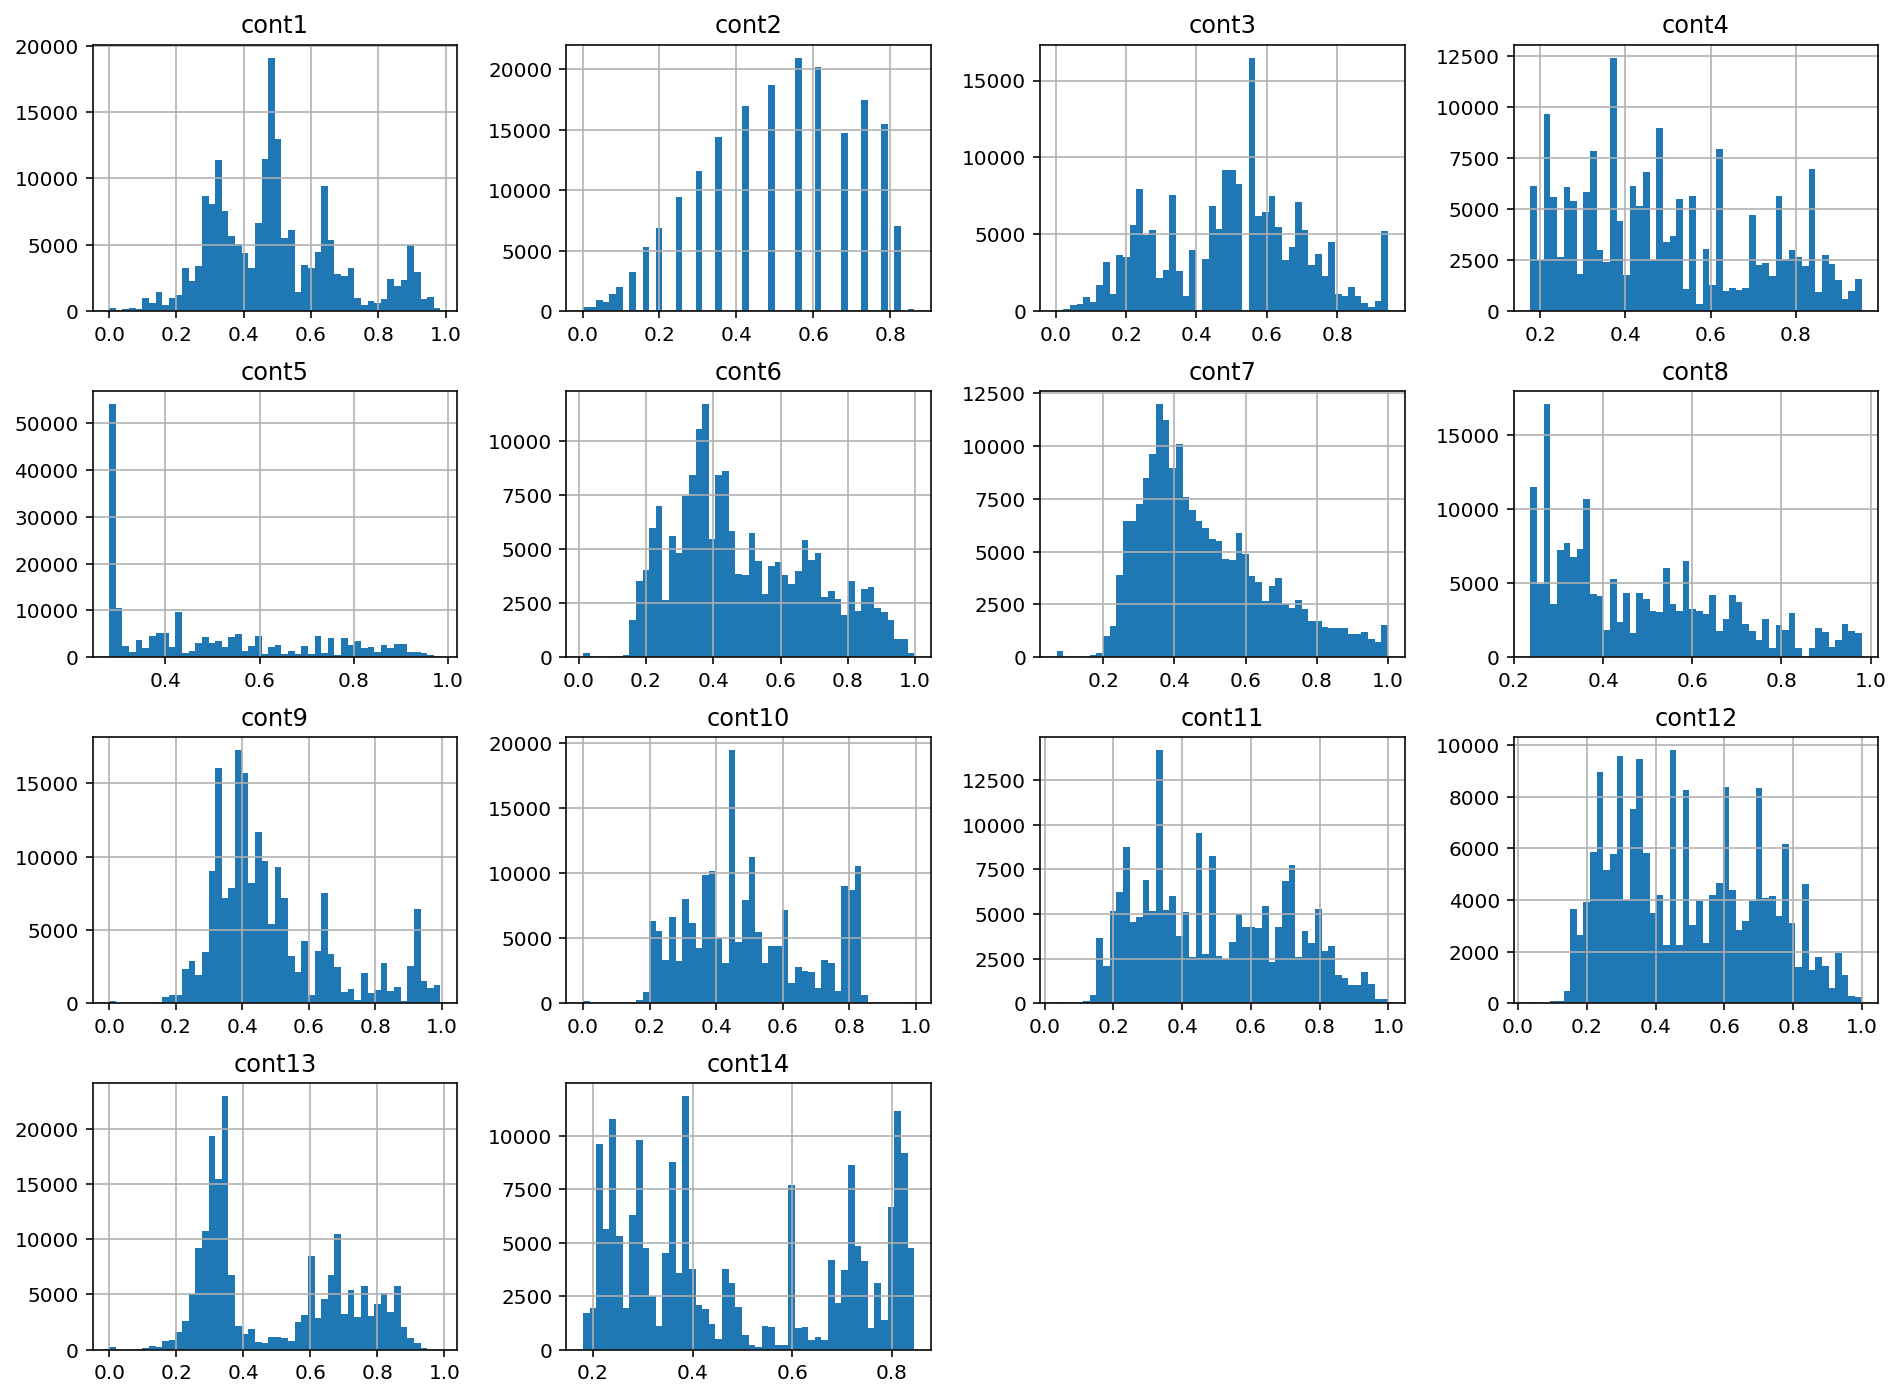

In [17]:
train[cont_features].hist(bins=50,figsize=(16,12))

特征之间的相关性

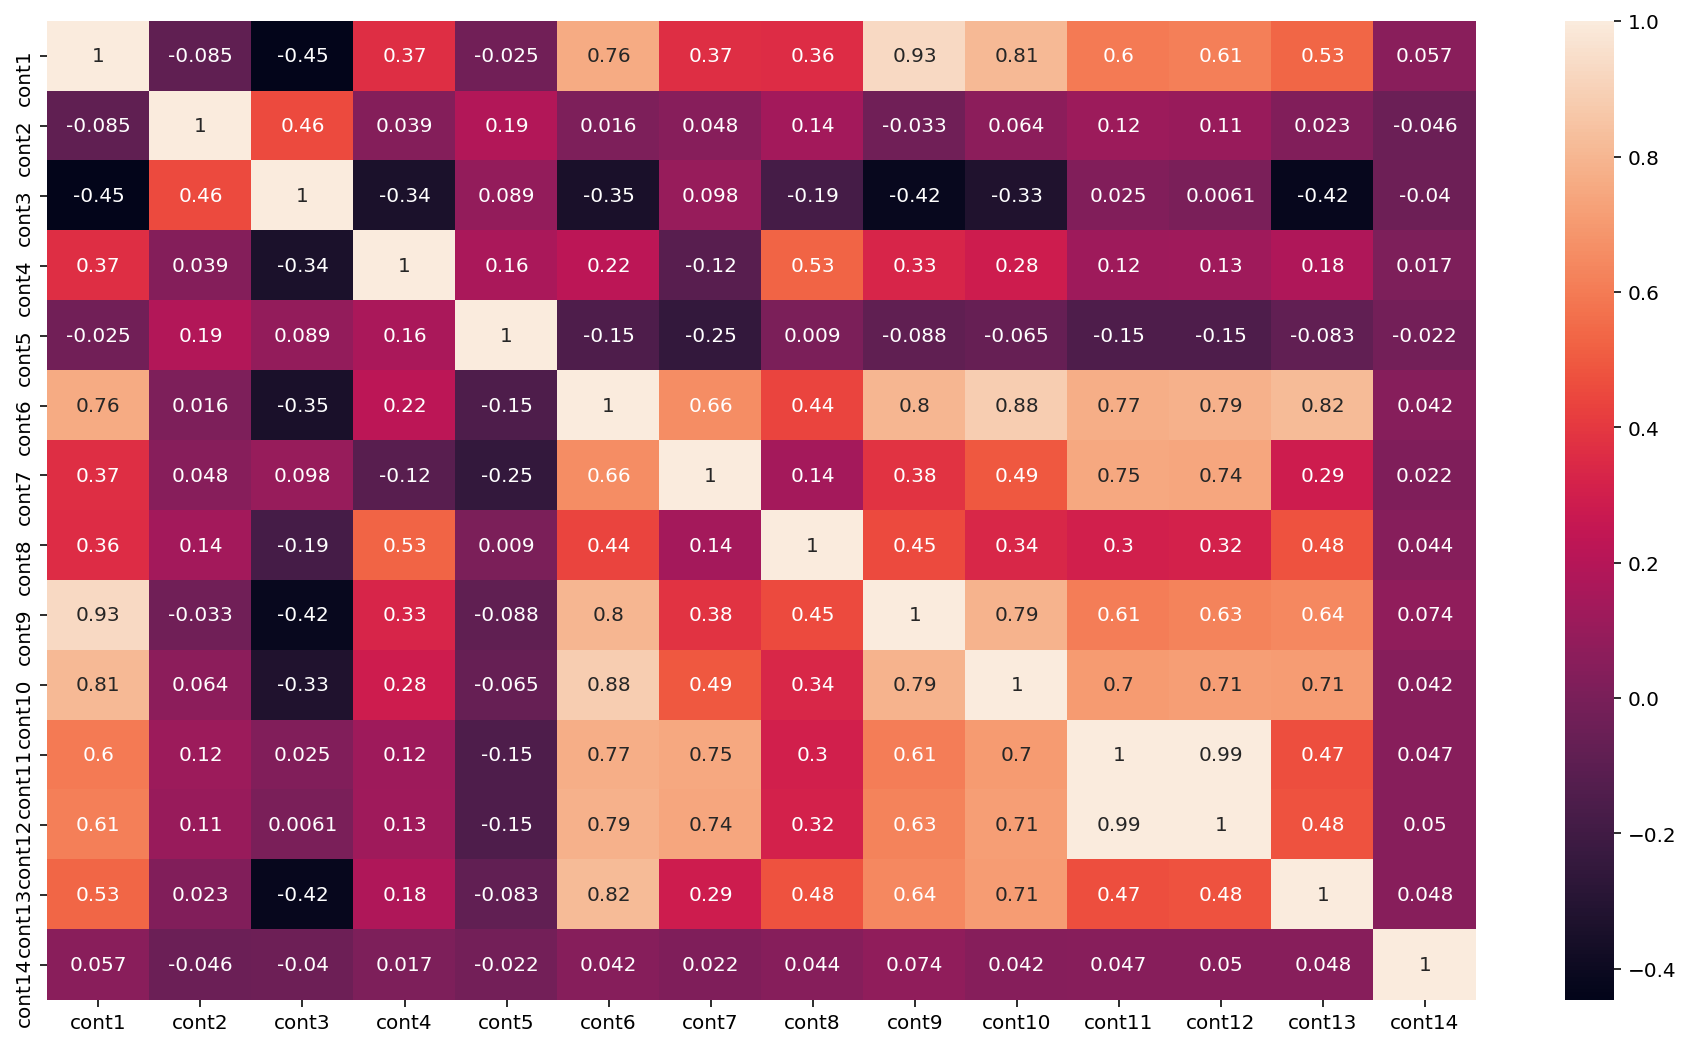

In [18]:
plt.subplots(figsize=(16,9))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat,annot=True)

## 二、XGBoost调参策略
导入依赖

In [19]:
import pandas as pd 
import numpy as np
import xgboost as xgb
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import KFold,train_test_split

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [20]:
train = pd.read_csv('dataset/train.csv')
train['log_loss']=np.log(train['loss'])

features = [x for x in train.columns if x not in ['id','loss','log_loss']]

cat_features =[x for x in train.select_dtypes(include = ['object']) if x not in ['id','loss','log_loss']]

num_features =[x for x in train.select_dtypes(exclude = ['object']) if x not in ['id','loss','log_loss']]           

print('离散特征Categorical: {} features'.format(len(cat_features)))
print('Numerical:{} features'.format(len(num_features)))

离散特征Categorical: 116 features
Numerical:14 features


In [21]:
ntrain = train.shape[0]
train_x = train[features]
train_y = train['log_loss']

In [22]:
for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
print('Xtrain:',train_x.shape) # Xtrain: (188318, 130)
print('ytrain:',train_y.shape) # ytrain: (188318,)

train_x

Xtrain: (188318, 130)
ytrain: (188318,)


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0,1,0,0,0,0,0,0,1,0,...,0.939556,0.242437,0.289949,0.24564,0.30859,0.32935,0.223038,0.220003,0.333292,0.208216
188314,0,0,0,0,0,1,0,0,0,0,...,0.704268,0.334270,0.382000,0.63475,0.40455,0.47779,0.307628,0.301921,0.318646,0.305872
188315,0,1,0,0,0,0,0,1,1,0,...,0.482436,0.345883,0.370534,0.24564,0.45808,0.47779,0.445614,0.443374,0.339244,0.503888
188316,0,1,0,0,0,0,0,0,1,1,...,0.340543,0.704364,0.562866,0.34987,0.44767,0.53881,0.863052,0.852865,0.654753,0.721707


### Simple XGBoost Model
首先，我们训练一个基本的xgboost模型，然后进行参数调节通过交叉验证来观察结果的变换，使用平均绝对误差衡量 mean_absolute_error(np.exp(y),np.exp(yhat))。

xgboost 自定义一个数据矩阵类 DMatrix，会在训练开始时，进行一边预处理，从而提高之后每次迭代的效率

### 结果衡量方法

In [23]:
#评估策略，e的次幂，用来评估。
#结果衡量方法：使用平均绝对误差来衡量
#mean_absolute_error(np.exp(y), np.exp(yhat))。
#定义计算损失值的函数
def xg_eval_mae(yhat,dtrain):
    y = dtrain.get_label()
    return 'mae',mean_absolute_error(np.exp(y),np.exp(yhat))

### Model

In [24]:
#数据类型转换成库可以使用的底层格式。
dtrain = xgb.DMatrix(train_x,train['log_loss'])
dtrain

### XGBoost参数
* booster : gbtree, 用什么方法进行结点分裂。梯度提升树来进行结点分裂。
* objective : multi softmax, 使用的损失函数，softmax 是多分类问题
* num_class : 10, 类别数，与 multi softmax 并用
* gamma : 损失下降多少才进行分裂
* max_depth : 12, 构建树的深度, 越大越容易过拟合
* lambda : 2, 控制模型复杂度的权重值的L2正则化项参数，参数越大。模型越不容易过拟合。
* subsample : 0.7 , 随机采样训练样本，取70%的数据训练
* colsample_bytree : 0.7, 生成树时进行的列采样
* min_child_weight : 3, 孩子节点中最小的样本权重和，如果一个叶子结点的样本权重和小于 min_child_weight 则拆分过程结果
* slient : 0, 设置成 1 则没有运行信息输出，最好是设置为0
* eta : 0.007, 如同学习率。前面的树都不变了，新加入一棵树后对结果的影响占比
* seed : 1000
* Thread : 7, cup 线程数

In [25]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

使用交叉验证 xgb.cv

In [26]:
%%time

#feval:评估策略
bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

[13:25:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:25:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

<Figure size 432x288 with 0 Axes>

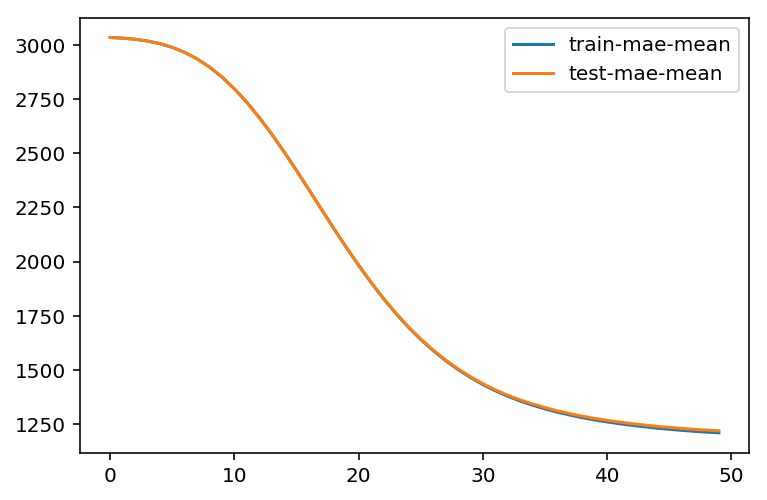

In [27]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot() 

上面是我们第一个模型

* 没有发生过拟合
* 只建立了50个树模型


In [28]:
%%time
#建立100个树模型
bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

[13:26:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

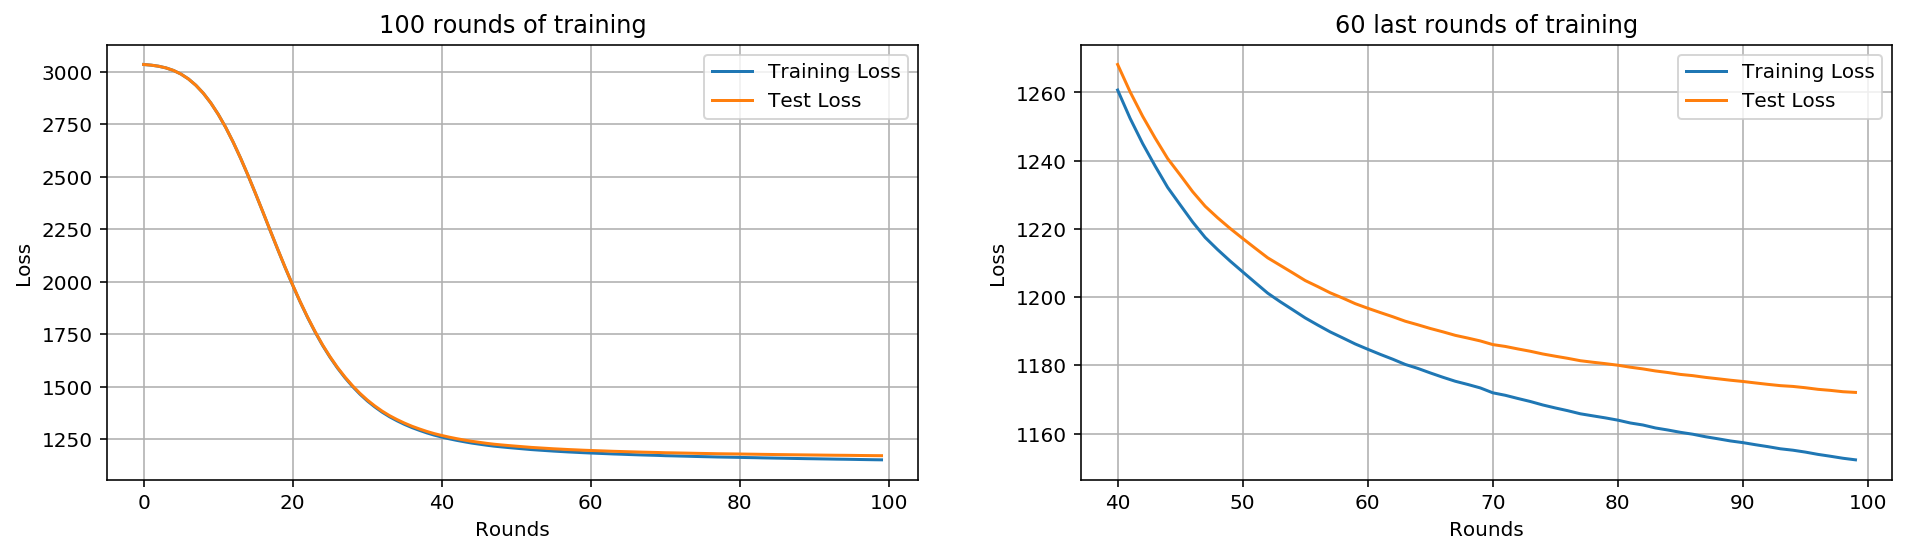

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss']) 

我们把树模型的数量增加到了100。效果不是很明显。看最后的60次。我们可以看到 测试集仅比训练集高那么一丁点。存在一丁点的过拟合。

不过我们的CV score更低了。接下来，我们改变其他参数。

### XGBoost参数调节
Step 1: 选择一组初始参数  
Step 2: 改变 max_depth 和 min_child_weight.  
Step 3: 调节 gamma 降低模型过拟合风险.  
Step 4: 调节 subsample 和 colsample_bytree 改变数据采样策略.  
Step 5: 调节学习率 eta. 

### step1：基准模型

In [30]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})#默认参数
        
    def fit(self, x_train, y_train):
        '''
        #数据类型转换,#用参数去训练xgboost模型
        '''
        dtrain = xgb.DMatrix(x_train, y_train) 
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self 

In [31]:
#衡量标准
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)

bst.kfold(train_x, train_y, nfold=5)

[13:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

train-rmse-mean       0.558937
train-rmse-std        0.001005
test-rmse-mean        0.562665
test-rmse-std         0.002445
train-mae-mean     1209.707324
train-mae-std         3.004207
test-mae-mean      1218.884204
test-mae-std          8.982969
Name: 49, dtype: float64

按照训练集处理方式，处理我们的测试集

In [32]:
test = pd.read_csv('dataset/test.csv')

test # 没有loss列,loss需要预测

#features_test = [x for x in test.columns if x not in ['id']]

test_x = test[features]

#将类别数据的类别用数字替换
for c in range(len(cat_features)):

    test_x[cat_features[c]] = test_x[cat_features[c]].astype('category').cat.codes

test_x.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,0,0,0,0,0,1,0,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,0,1,0,1,0,0,0,0,1,0,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,0,1,0,1,1,0,1,0,1,1,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,0,0,0,0,1,0,0,0,0,0,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,1,0,0,0,0,1,0,0,0,0,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


In [33]:
#数据类型转换成库可以使用的底层格式。
dtest_x = xgb.DMatrix(test_x)
#dtest_x
#得到我们想要的测试集


#预测命令：
#xgb.predict(dtest_x)
test_y = bst.predict(test_x)

test_y[1],len(test_y)

[13:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




(7.450635, 125546)

In [34]:
import math

#math.exp(test_y[0])
test_exp_y= np.zeros(len(test_y))
for i in range(len(test_y)):
    test_exp_y[i] = math.exp(test_y[i])
test_exp_y.shape

(125546,)

### step2：树的深度与节点权重|
这些参数对xgboost性能影响最大，因此，他们应该调整第一。我们简要地概述它们： 
* max_depth: 树的最大深度。增加这个值会使模型更加复杂，也容易出现过拟合，深度3-10是合理的。 
* min_child_weight: 正则化参数. 如果树分区中的实例权重小于定义的总和，则停止树构建过程。

In [35]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
xgb_param_grid['max_depth'] 

[4, 5, 6, 7, 8]

In [36]:
%%time
from sklearn.model_selection import GridSearchCV

#交叉验证 网格搜索
grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                param_grid=xgb_param_grid, cv=5, scoring = mae_scorer)

grid.fit(train_x, train_y.values)



[13:28:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:28:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

KeyboardInterrupt: 

In [37]:

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<__main__.XGBoostRegressor object at 0x000001EAF043AAC8>,
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 3, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae_score, greater_is_better=False),
             verbose=0)

#grid.grid_scores_, grid.best_params_, grid.best_score_  #旧版本

#print(grid.cv_results_)#新版本
print(grid.cv_results_['mean_test_score'])
print(grid.cv_results_['params'])
print('************************************')
print(grid.best_params_)
print('************************************')
print(grid.best_score_ )

SyntaxError: invalid syntax (<ipython-input-37-9e4d82822ec9>, line 2)